# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [3]:
trainData = pd.read_csv("H:\\MSIT 2nd Year\\Data Science\\6030_DataScience\\week 3\\HW 4\\Bikeshare_train.csv")
testData = pd.read_csv("H:\\MSIT 2nd Year\\Data Science\\6030_DataScience\\week 3\\HW 4\\Bikeshare_test.csv")

In [4]:
trainData

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0
5,5,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,69.7083,0.342667,4451.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,7.0,11.0,33.3478,0.347835,5315.0
7,7,2.0,6.0,0.0,2.0,1.0,1.0,23.0,26.0,50.7083,0.269283,4891.0
8,8,3.0,9.0,0.0,6.0,0.0,1.0,23.0,26.0,50.1667,0.247521,8714.0
9,9,3.0,8.0,0.0,3.0,1.0,1.0,30.0,30.0,61.9583,0.169771,7347.0


In [5]:
testData

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


In [5]:
print(trainData.dtypes)
print("------------------------")
print(testData.dtypes)

Unnamed: 0       int64
season         float64
month          float64
holiday        float64
day_of_week    float64
workingday     float64
weather        float64
temp           float64
atemp          float64
humidity       float64
windspeed      float64
count          float64
dtype: object
------------------------
Unnamed: 0       int64
season         float64
month          float64
holiday        float64
day_of_week    float64
workingday     float64
weather        float64
temp           float64
atemp          float64
humidity       float64
windspeed      float64
count          float64
dtype: object


(array([111.,  45.,  41.,  41.,  93.]),
 array([0. , 1.2, 2.4, 3.6, 4.8, 6. ]),
 <a list of 5 Patch objects>)

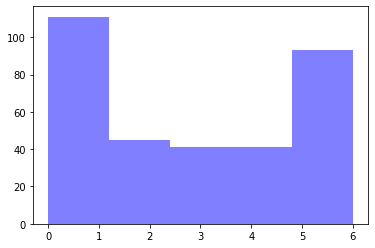

In [6]:
plt.hist(trainData['day_of_week'], 5, facecolor='blue', alpha=0.5)

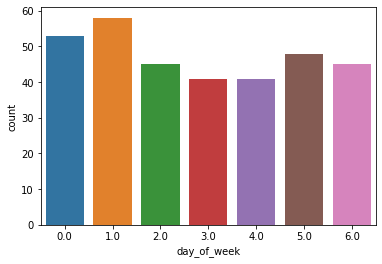

In [11]:
sns.countplot(x='day_of_week',data=trainData)

[222, 109]
Average rentals on working Day:  4665.896396396396
Average rentals on non-working Day:  4461.073394495413


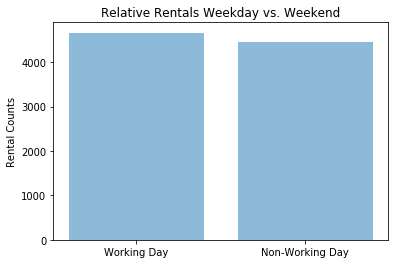

In [12]:
#average rentals on weekdays and weekend
nonWorking = trainData.loc[trainData['workingday'] == 0, 'count'].sum()
working = trainData.loc[trainData['workingday'] == 1, 'count'].sum()
totalEntries = list(pd.value_counts(trainData['workingday'].values))
avgWorking = working/totalEntries[0]
avgNonWorking = nonWorking/totalEntries[1]
print(totalEntries)
print("Average rentals on working Day: ",avgWorking)
print("Average rentals on non-working Day: ",avgNonWorking)
#for plotting we have to assign the values in a list
plotValues = [avgWorking, avgNonWorking]
y_pos = np.arange(len(plotValues))
plt.bar(y_pos, plotValues, align='center', alpha=0.5)
plt.xticks(y_pos, ['Working Day', 'Non-Working Day'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals Weekday vs. Weekend')
plt.show()

[320, 11]
Average rentals on Holiday:  4612.171875
Average rentals on non-Holiday:  4199.181818181818


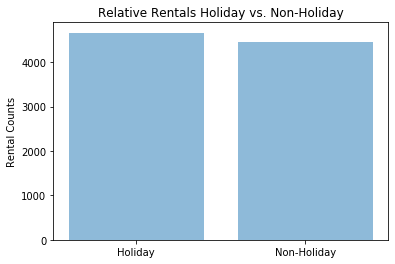

In [13]:
#bike rentals on holidays vs non-holidays
holiday = trainData.loc[trainData['holiday'] == 0, 'count'].sum()
nonHoliday = trainData.loc[trainData['holiday'] == 1, 'count'].sum()
totalEntries = list(pd.value_counts(trainData['holiday'].values,sort=False))
avgHoliday = holiday/totalEntries[0]
avgNonHoliday = nonHoliday/totalEntries[1]
print(totalEntries)
print("Average rentals on Holiday: ",avgHoliday)
print("Average rentals on non-Holiday: ",avgNonHoliday)
#for plotting we have to assign the values in a list
plotValues = [avgWorking, avgNonWorking]
y_pos = np.arange(len(plotValues))
plt.bar(y_pos, plotValues, align='center', alpha=0.5)
plt.xticks(y_pos, ['Holiday', 'Non-Holiday'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals Holiday vs. Non-Holiday')
plt.show()

[86, 85, 88, 72]
Average rentals by seasons: Spring Summer Fall Winter  [2210.0, 5044.4, 5680.738636363636, 5602.041666666667]


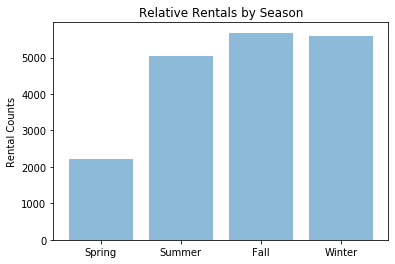

In [14]:
#rentals distributed by seasons
#season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
spring= trainData.loc[trainData['season'] == 1, 'count'].sum()
summer = trainData.loc[trainData['season'] == 2, 'count'].sum()
fall = trainData.loc[trainData['season'] == 3, 'count'].sum()
winter = trainData.loc[trainData['season'] == 4, 'count'].sum()
totalEntries = list(pd.value_counts(trainData['season'].values,sort=False))
print(totalEntries)
avgSpring = spring/totalEntries[0]
avgSummer = summer/totalEntries[1]
avgFall = fall/totalEntries[2]
avgWinter = winter/totalEntries[3]
#for plotting we have to assign the values in a list
plotValues = [avgSpring, avgSummer, avgFall, avgWinter]
y_pos = np.arange(len(plotValues))
print("Average rentals by seasons: Spring Summer Fall Winter ",plotValues)
plt.bar(y_pos, plotValues, align='center', alpha=0.5)
plt.xticks(y_pos, ['Spring', 'Summer','Fall','Winter'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals by Season')
plt.show()

Average rentals by weather:  [9727.642201834862, 2096.2783018867926, 1736.2, 0]


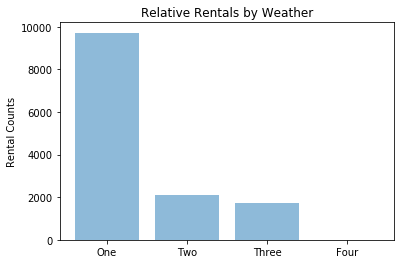

In [15]:
#How are rentals impacted by weather conditions
#weather
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
one= trainData.loc[trainData['weather'] == 1, 'count'].sum()
two = trainData.loc[trainData['weather'] == 2, 'count'].sum()
three = trainData.loc[trainData['weather'] == 3, 'count'].sum()
four = trainData.loc[trainData['weather'] == 4, 'count'].sum()
totalEntries = list(pd.value_counts(trainData['weather'].values,sort=False))
#some values are missing in the table
try:
    avgOne = one/totalEntries[0]
except:
    avgOne = 0
try:
    avgTwo = two/totalEntries[1]
except:
    avgTwo = 0
try:
    avgThree = three/totalEntries[2]
except:
    avgThree = 0
try:
    avgFour = four/totalEntries[3]
except:
    avgFour = 0
#for plotting we have to assign the values in a list
plotValues = [avgOne, avgTwo, avgThree, avgFour]
y_pos = np.arange(len(plotValues))
print("Average rentals by weather: ",plotValues)
plt.bar(y_pos, plotValues, align='center', alpha=0.5)
plt.xticks(y_pos, ['One', 'Two','Three','Four'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals by Weather')
plt.show()

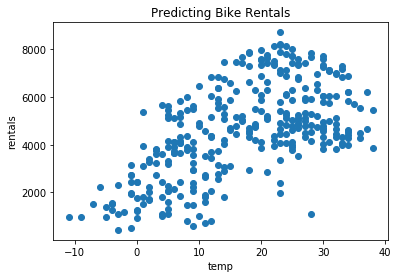

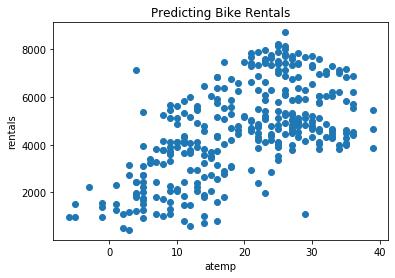

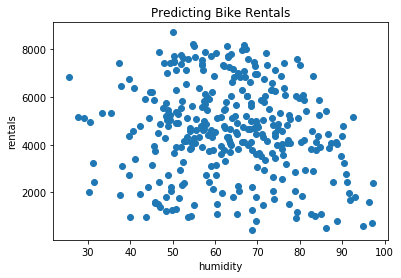

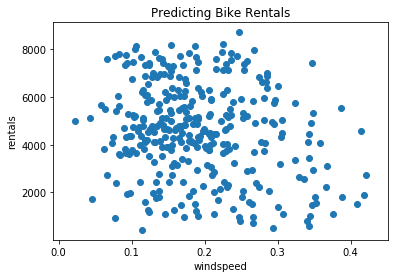

In [16]:
#How are rentals impacted by temperature
#there are four factors - temp,atemp,humidity and windspeed
factors = ['temp', 'atemp', 'humidity', 'windspeed']
for i in factors:
    x = trainData[i]
    y = trainData['count']
    
    plt.scatter(x, y)
    plt.xlabel(i)
    plt.ylabel('rentals')
    plt.title('Predicting Bike Rentals')
    plt.show()

your answers here

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

your answers here

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [17]:
#train and test will have same data except count column
Xtrain, ytrain = trainData.drop('count', axis =1), trainData['count'].values.reshape(-1,1)
Xtest, ytest = testData.drop('count', axis =1), testData['count'].values.reshape(-1, 1)
#building a multiple regression model
multipleReg = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()
ytest_pred = multipleReg.predict(sm.add_constant(Xtest))
ytrain_pred = multipleReg.predict(sm.add_constant(Xtrain))
multipleReg.summary()

c:\users\someshwar thumma\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     29.22
Date:                Sun, 08 Sep 2019   Prob (F-statistic):           4.13e-42
Time:                        18:59:44   Log-Likelihood:                -2858.8
No. Observations:                 331   AIC:                             5742.
Df Residuals:                     319   BIC:                             5787.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4309.1335    582.240      7.401      0.000    3163.619    5454.649
Unnamed: 0      0.2049      0.805      0.255      0.799      -1.379       1.788
season        469.4230    138.269      3.395      0.001     197.389     741.457
month         -28.4239     44.038     -0.645      0.519    -115.065      58.218
holiday      -320.7963    448.744     -0.715      0.475   -1203.667     562.075
day_of_week    85.3508     38.023      2.245      0.025      10.542     160.159
workingday    132.0354    170.619      0.774      0.440    -203.646     467.717
weather      -415.4527    199.223     -2.085      0.038    -807.409     -23.496
temp           35.6004     38.736      0.919      0.359     -40.611     111.812
atemp          62.3174     43.893      1.420      0.157     -24.038     148.673
humidity      -28.1259      7.820     -3.597      0.000     -43.511     -12.740
windspeed   -2848.4230   1068.062     -2.667      0.008   -4949.759    -747.087
==============================================================================
Omnibus:                       20.240   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.057
Skew:                           0.058   Prob(JB):                       0.0178
Kurtosis:                       2.244   Cond. No.                     2.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

your answers here

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

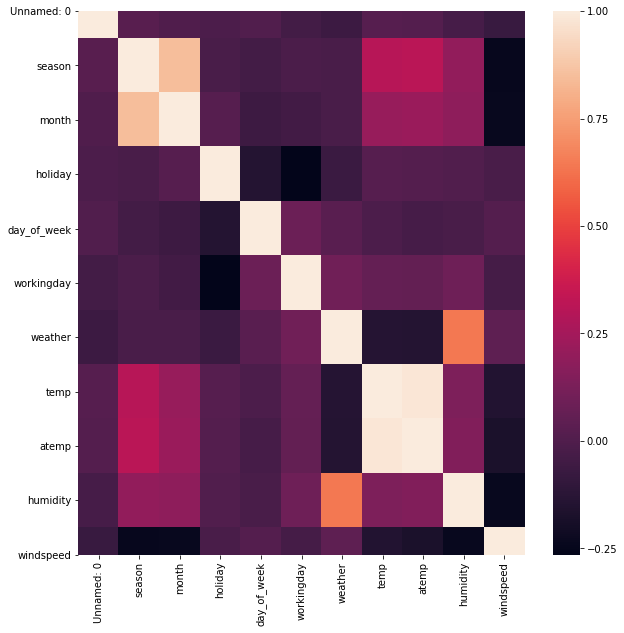

In [22]:
correlation = trainData.drop('count', axis = 1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation)

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [23]:
def forwardSelection(trainData, ytrain):
    S = []
    results = {}
    for i in range(len(trainData.columns)-1):
        model_results = {}
        for column in trainData.drop(S+['count'], axis =1).columns:
            test_set = S+[str(column)]
            model = sm.OLS(ytrain, sm.add_constant(trainData[test_set])).fit()
            model_results[model.bic] = test_set 
        minimum = min(model_results.keys())
        minimum_set= model_results[minimum]
        S+=minimum_set
        S = list(set(S))
        results[minimum] = minimum_set
    key = min(results.keys())
    return results[key], key

def backwardSelection(trainData, ytrain):
    dropped =['count']
    S = list(trainData.columns)
    results = {}
    for i in range(len(trainData.columns)-2):
        model_results = {}
        for column in trainData.drop(dropped, axis =1).columns:
            test_set = [x for x in trainData.columns if x not in dropped +[str(column)]] 
            model = sm.OLS(ytrain, sm.add_constant(trainData[test_set])).fit()
            model_results[model.bic] =  test_set
        minimum = min(model_results.keys())
        minimum_key = model_results[minimum]
        dropped = [x for x in trainData.columns if x not in minimum_key]
        results[minimum] = minimum_key
    key = min(results.keys())    
    return results[key], key

In [24]:
forward_set, backward_set = forwardSelection(trainData, ytrain)[0], backwardSelection(trainData, ytrain)[0]
forward_params, backward_params = trainData[forward_set], trainData[backward_set]
forward_df, backward_df = trainData[forward_set + ['count']], trainData[backward_set + ['count']]
forward_model = sm.OLS(ytrain, sm.add_constant(forward_params)).fit()
forward_pred = forward_model.predict(sm.add_constant(forward_params))
backward_model = sm.OLS(ytrain, sm.add_constant(backward_params)).fit()
backward_pred = backward_model.predict(sm.add_constant(backward_params))

In [25]:
print('Train R2 for forward:', r2_score(ytrain, forward_model.predict(sm.add_constant(forward_params))))
print('Test R2 for forward:', r2_score(ytest, forward_pred))

Train R2 for forward: 0.4972931995054056


ValueError: Found input variables with inconsistent numbers of samples: [400, 331]

In [22]:
print('Train R2 for backward:',r2_score(ytrain, backward_model.predict(sm.add_constant(backward_params))))
print('Test R2 for backward', r2_score(ytest, backward_pred))

Train R2 for backward: 0.4912522260331563


c:\users\itsvi\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ValueError: Found input variables with inconsistent numbers of samples: [400, 331]

your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [26]:
lm = LinearRegression(fit_intercept=True)
scores = cross_val_score(lm, Xtrain, ytrain, cv=10)
average = np.mean(scores)
print('Cross-validated scores', scores)
print('Average of folds', average)

Cross-validated scores [ 0.59989431  0.47944955  0.34487436  0.01248137  0.44866059 -0.4977368
  0.31702852  0.37014348  0.53001857  0.54885642]
Average of folds 0.3153670375103038


# Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [27]:
alphaValues = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
ridgeModels = {}
lassoModels = {}

for alpha in alphaValues:

    ridge_reg = Ridge(alpha = alpha)
    lasso_reg = Lasso(alpha = alpha)

    scores_r = cross_val_score(ridge_reg, Xtrain, ytrain, cv=10)
    score_r = np.mean(scores_r)
    temp_dict_r = {alpha : score_r}
    ridgeModels.update(temp_dict_r)
    
    scores_l = cross_val_score(lasso_reg, Xtrain, ytrain, cv=10)
    score_l = np.mean(scores_l)
    temp_dict_l = {alpha : score_l}
    lassoModels.update(temp_dict_l)



best_lasso_alpha = max(lassoModels, key=lassoModels.get)
best_lasso_score =lassoModels.get(best_lasso_alpha)

best_ridge_alpha = max(ridgeModels, key=ridgeModels.get)
best_ridge_score =ridgeModels.get(best_ridge_alpha)

print('The best ridge model has alpha=', best_ridge_alpha)
print('The best ridge model has score=', best_ridge_score)

print('The best lasso model has alpha=', best_lasso_alpha)
print('The best lasso model has score=', best_lasso_score)

c:\users\someshwar thumma\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262373319.75544766, tolerance: 109971.05369832215
  positive)
c:\users\someshwar thumma\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262105520.80808666, tolerance: 109971.05369832215
  positive)
c:\users\someshwar thumma\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259449947.79880497, tolerance: 109971.05369832215
  positive)
c:\users\someshwar thumma\appdata\local\programs\python\python37\lib\site-packa

The best ridge model has alpha= 1000
The best ridge model has score= 0.37246209980798106
The best lasso model has alpha= 100
The best lasso model has score= 0.3589791134659935


In [28]:
# fit best validated
ridge_reg = Ridge(alpha = best_ridge_alpha)
lasso_reg = Lasso(alpha = best_lasso_alpha)
#fit the model(training data)
ridge_reg.fit(Xtrain, ytrain)  
lasso_reg.fit(Xtrain, ytrain)
#ridge beta coefficients
beta0_ridge = ridge_reg.intercept_
betas_ridge = ridge_reg.coef_
#lasso beta coefficients
beta0_lasso = lasso_reg.intercept_
betas_lasso = lasso_reg.coef_
#predict
ypredict_ridge = ridge_reg.predict(Xtrain)
ypredict_lasso = lasso_reg.predict(Xtrain)
print('Ridge Beta0 is:', beta0_ridge)
print('Ridge Betas are:', betas_ridge)
print('Lasso Beta0 is:', beta0_lasso)
print('Lasso Betas are:', betas_lasso)

Ridge Beta0 is: [3781.14303685]
Ridge Betas are: [[  0.58109059  64.35905219  74.51122527  -4.68934726  51.32917866
   11.22916077 -26.85812931  45.56411057  63.6588252  -32.70697354
   -6.4913063 ]]
Lasso Beta0 is: [3552.76356767]
Lasso Betas are: [  0.52421688 258.46237895  34.71919796  -0.          65.83728738
   0.          -0.          28.63224791  80.22954929 -34.34130742
  -0.        ]


In [29]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x.iloc[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

In [30]:

simpl_reg = LinearRegression()
sample_sizes = [100, 150, 200, 250, 300, 350, 400]
columns = ['sample_size', 'avg_training_ridge', 'SD_train_ridge', 'CI_train_ridge', 'avg_test_ridge', 'SD_test_ridge', 
          'CI_test_ridge', 'avg_training_lasso', 'SD_train_lasso', 'CI_train_lasso', 'avg_test_lasso', 'SD_test_lasso', 
          'CI_test_lasso', 'avg_training_simpl', 'SD_train_simpl', 'CI_train_simpl', 'avg_test_simpl', 'SD_test_simpl',
          'CI_test_simpl']
dicts = []

# iterate through sample sizes
for sample_size in sample_sizes:
    
    scores_training_ridge = []
    scores_test_ridge = []
    scores_training_lasso = []
    scores_test_lasso = []
    scores_training_simpl = []
    scores_test_simpl = []
    
    # repeate 10 times for each fit
    for i in range(0, 10):
        sample_X, sample_y = sample(Xtrain, ytrain, sample_size)
        ridge_reg.fit(sample_X, sample_y)  
        lasso_reg.fit(sample_X, sample_y)
        simpl_reg.fit(sample_X, sample_y)
        
        pred_training_ridge = ridge_reg.predict(sample_X)
        pred_test_ridge = ridge_reg.predict(Xtest)
        
        pred_training_lasso = lasso_reg.predict(sample_X)
        pred_test_lasso = lasso_reg.predict(Xtest)
        
        pred_training_simpl =simpl_reg.predict(sample_X)
        pred_test_simpl = simpl_reg.predict(Xtest)
        
        # r2 scores
        score_training_ridge = r2_score(sample_y, pred_training_ridge)
        scores_training_ridge.append(score_training_ridge)
        score_test_ridge = r2_score(ytest, pred_test_ridge)
        scores_test_ridge.append(score_test_ridge)
        
        score_training_lasso = r2_score(sample_y, pred_training_lasso)
        scores_training_lasso.append(score_training_lasso)
        score_test_ridge = r2_score(ytest, pred_test_lasso)
        scores_test_lasso.append(score_test_ridge)
        
        score_training_simpl = r2_score(sample_y, pred_training_simpl)
        scores_training_simpl.append(score_training_simpl)
        score_test_simpl = r2_score(ytest, pred_test_simpl)
        scores_test_simpl.append(score_test_simpl)
        
    # averages over the 10 trials
    avg_test_ridge = np.mean(scores_test_ridge)
    avg_test_lasso = np.mean(scores_test_lasso)
    avg_test_simpl = np.mean(scores_test_simpl)
    avg_training_ridge = np.mean(scores_training_ridge)
    avg_training_lasso = np.mean(scores_training_lasso)
    avg_training_simpl = np.mean(scores_training_simpl)
        
    # compute standard deviations of errors for training and test sets for each regression
    SD_train_ridge = np.std(scores_training_ridge)
    SD_train_lasso = np.std(scores_training_lasso)
    SD_train_simpl = np.std(scores_training_simpl)
    SD_test_ridge = np.std(scores_test_ridge)
    SD_test_lasso = np.std(scores_test_lasso)
    SD_test_simpl = np.std(scores_test_simpl)
    
    # compute confidance intervals
    CI_train_ridge = [avg_training_ridge-SD_train_ridge, avg_training_ridge+SD_train_ridge]
    CI_train_lasso = [avg_training_lasso-SD_train_lasso, avg_training_lasso+SD_train_lasso]
    CI_train_simpl = [avg_training_simpl-SD_train_simpl, avg_training_simpl+SD_train_simpl]
    CI_test_ridge = [avg_test_ridge-SD_train_ridge, avg_test_ridge+SD_test_ridge]
    CI_test_lasso = [avg_test_lasso-SD_train_lasso, avg_test_lasso+SD_test_lasso]
    CI_test_simpl = [avg_test_simpl-SD_train_simpl, avg_test_simpl+SD_test_simpl]
   
   
    
    # create a data structure to store our values
    temp_dict = {'sample_size': sample_size, 'avg_training_ridge' : avg_training_ridge, 'SD_train_ridge' : SD_train_ridge, 'CI_train_ridge' : CI_train_ridge, 'avg_test_ridge' : avg_test_ridge, 
                'CI_test_simpl' : CI_test_simpl, 'CI_test_lasso' : CI_test_lasso, 'CI_test_ridge' : CI_test_ridge, 'CI_train_simpl' : CI_train_simpl, 'CI_train_lasso' :  CI_train_lasso, 'SD_test_lasso' : SD_test_lasso, 'SD_test_ridge' :  SD_test_ridge, 'avg_training_lasso' : avg_training_lasso, 'SD_train_lasso' : SD_train_lasso, 'avg_test_lasso' : avg_test_lasso,
                'avg_training_simpl' : avg_training_simpl, 'SD_train_simpl' : SD_train_simpl, 'avg_test_simpl' : avg_test_simpl, 'SD_test_simpl' : SD_test_simpl} 
    dicts.append(temp_dict)
   
df = pd.DataFrame(dicts) 
df = df[columns]

In [31]:
df.head()

,sample_size,avg_training_ridge,SD_train_ridge,CI_train_ridge,avg_test_ridge,SD_test_ridge,CI_test_ridge,avg_training_lasso,SD_train_lasso,CI_train_lasso,avg_test_lasso,SD_test_lasso,CI_test_lasso,avg_training_simpl,SD_train_simpl,CI_train_simpl,avg_test_simpl,SD_test_simpl,CI_test_simpl
0,100,0.417554,0.062082,"[0.3554719046995128, 0.47963587899313204]",0.228210,0.014505,"[0.16612837730941432, 0.24271586259794806]",0.467033,0.069964,"[0.39706955223476514, 0.5369967738226957]",0.217023,0.025553,"[0.14705943647825828, 0.24257622309263835]",0.515496,0.060434,"[0.45506166874877574, 0.5759297219216052]",0.184156,0.035800,"[0.12372218683138977, 0.21995611794982511]"
1,150,0.473422,0.046267,"[0.4271549491680358, 0.5196889879167315]",0.225298,0.019706,"[0.17903128615704844, 0.24500472688008415]",0.507556,0.051895,"[0.4556610401100317, 0.559451057350374]",0.221678,0.027499,"[0.16978306753167297, 0.24917683472847685]",0.545708,0.049001,"[0.4967070168148321, 0.594708102632845]",0.211989,0.029309,"[0.16298813497454617, 0.2412976508856388]"
2,200,0.475388,0.037456,"[0.4379313677096687, 0.5128440679067351]",0.230878,0.012987,"[0.19342184903311793, 0.24386557961739258]",0.507370,0.036929,"[0.4704412170537029, 0.544298432119011]",0.229587,0.021912,"[0.1926585295667274, 0.25149936081810287]",0.548950,0.035522,"[0.5134286128901736, 0.584471855673271]",0.216943,0.046152,"[0.18142111919596035, 0.26309461047940974]"
3,250,0.480982,0.033881,"[0.4471013128448162, 0.5148633186843992]",0.228852,0.012599,"[0.19497129937391883, 0.24145096878019964]",0.515096,0.042861,"[0.4722351122844631, 0.5579565724869372]",0.221087,0.015040,"[0.17822637417561837, 0.2361270333560162]",0.544394,0.045353,"[0.4990410431294084, 0.5897461778581035]",0.205571,0.039976,"[0.16021798271472243, 0.24554650211556908]"
4,300,0.487865,0.036391,"[0.45147432496389983, 0.5242555850956316]",0.231474,0.013090,"[0.19508341336282858, 0.2445641609401824]",0.506072,0.036886,"[0.4691864822398968, 0.5429578045552319]",0.229282,0.017124,"[0.19239637888630753, 0.24640623699490533]",0.540986,0.037402,"[0.5035837858715693, 0.5783882582220994]",0.232966,0.026214,"[0.19556403181441062, 0.2591800975724855]"


Text(0.5, 1.0, 'Simple Regression Test R2 Scores')

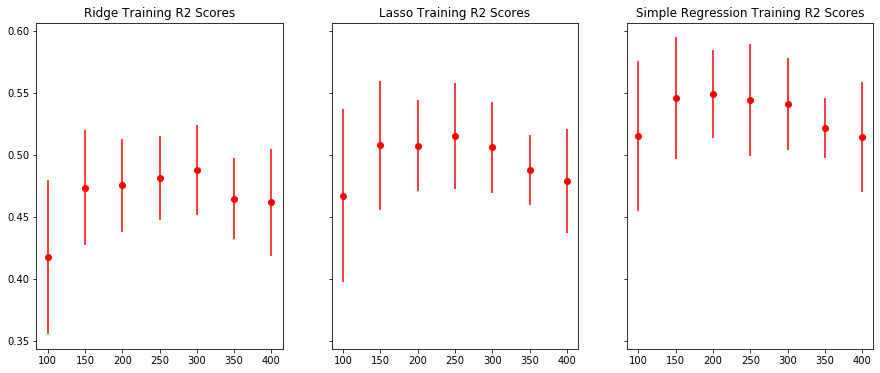

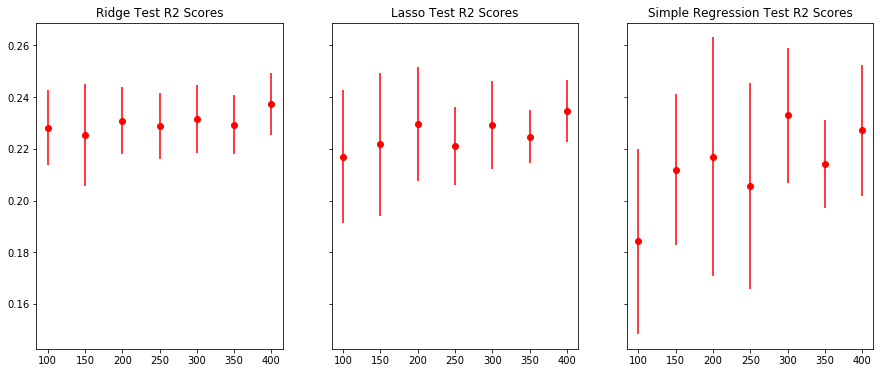

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,6))

ax1.errorbar(df.sample_size.values, df.avg_training_ridge.values, c='red', yerr=df.SD_train_ridge.values, fmt='o')
ax1.set_title("Ridge Training R2 Scores")
ax1.set_ylabel="R2"
ax1.set_xlabel="sample size"

ax2.errorbar(df.sample_size.values, df.avg_training_lasso.values, c='red', yerr=df.SD_train_lasso.values, fmt='o')
ax2.set_title("Lasso Training R2 Scores")

ax3.errorbar(df.sample_size.values, df.avg_training_simpl.values, c='red', yerr=df.SD_train_simpl.values, fmt='o')
ax3.set_title("Simple Regression Training R2 Scores")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,6))
ax1.errorbar(df.sample_size.values, df.avg_test_ridge.values, c='red', yerr=df.SD_test_ridge.values, fmt='o')
ax1.set_title("Ridge Test R2 Scores")

ax2.errorbar(df.sample_size.values, df.avg_test_lasso.values, c='red', yerr=df.SD_test_lasso.values, fmt='o')
ax2.set_title("Lasso Test R2 Scores")

ax3.errorbar(df.sample_size.values, df.avg_test_simpl.values, c='red', yerr=df.SD_test_simpl.values, fmt='o')
ax3.set_title("Simple Regression Test R2 Scores")

Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from mean - SD to mean + SD. Make a similar plot for the test $R^2$ scores.
How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

Hint: You may use sklearn's RidgeCV and LassoCV classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the plt.errorbar function to plot confidence bars for the average $R^2$ scores.

Analysis

There is an inverse relationship between test and training R2 for the 3 regressions. The simple regression has the highest training R2. This is to be expected, as there is no penalty. However, the test R2 suffers as a result of this overfitting. The Lasso and Ridge, while having lower training R2, have much better performance on the testing data as a result of the regularization penalty. Ridge performs the best of the three for predicting on the test set for all sample sizes, Lasso only performs as well as Ridge when the sample size is large. As far as the confidence intervals, they tighten as the sample size increases. This is to be expected. Given a small sample size, we would use Ridge regression with an alpha value of 10.

Part (g): Polynomial & Interaction Terms¶
Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms.

For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%.

Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

Analysis

Our R2 on this part, compared to homework three is significantly better. Of our 40 predictors, 9 seem statistically significant based upon p values obtained from OLS. A few others are very close, perhaps warranting inclusion. Our model still has high dimensionality and high collinaearity, however.

In [35]:
trainData['temp^2'] = trainData['temp']**2
testData['temp^2'] = testData['temp']**2
trainData['temp^3'] = trainData['temp']**3
testData['temp^3'] = testData['temp']**3
trainData['temp^4'] = trainData['temp']**4
testData['temp^4'] = testData['temp']**4

trainData['atemp^2'] = (trainData['atemp'])**2
testData['atemp^2'] = (testData['atemp'])**2
trainData['atemp^3'] = (trainData['atemp'])**3
testData['atemp^3'] = (testData['atemp'])**3
trainData['atemp^4'] = (trainData['atemp'])**4
testData['atemp^4'] = (testData['atemp'])**4

trainData['humidity^2'] = (trainData['humidity'])**2
testData['humidity^2'] = (testData['humidity'])**2
trainData['humidity^3'] = (trainData['humidity'])**3
testData['humidity^3'] = (testData['humidity'])**3
trainData['humidity^4'] = (trainData['humidity'])**4
testData['humidity^4'] = (testData['humidity'])**4

trainData['windspeed^2'] = (trainData['windspeed'])**2
testData['windspeed^2'] = (testData['windspeed'])**2
trainData['windspeed^3'] = (trainData['windspeed'])**3
testData['windspeed^3'] = (testData['windspeed'])**3
trainData['windspeed^4'] = (trainData['windspeed'])**4
testData['windspeed^4'] = (testData['windspeed'])**4
print(trainData.columns)

Index(['Unnamed: 0', 'season', 'month', 'holiday', 'day_of_week', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'temp^2',
       'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2',
       'humidity^3', 'humidity^4', 'windspeed^2', 'windspeed^3',
       'windspeed^4'],
      dtype='object')


In [37]:
y_train = trainData['count'].values
X_train = trainData[['season', 'month', 'holiday', 'day_of_week', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'temp^2',
       'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2',
       'humidity^3', 'humidity^4', 'windspeed^2', 'windspeed^3',
       'windspeed^4']].values

y_test = testData['count'].values
X_test = testData[['season', 'month', 'holiday', 'day_of_week', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'temp^2',
       'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2',
       'humidity^3', 'humidity^4', 'windspeed^2', 'windspeed^3',
       'windspeed^4']].values

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [38]:
print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)
trainData

(331, 23) (331, 1) (400, 23) (400, 1)


,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,...,temp^4,atemp^2,atemp^3,atemp^4,humidity^2,humidity^3,humidity^4,windspeed^2,windspeed^3,windspeed^4
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,...,331776.0,676.0,17576.0,456976.0,5865.001839,449161.195328,3.439825e+07,0.013963,0.001650,0.000195
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,...,50625.0,361.0,6859.0,130321.0,5383.890625,395042.974609,2.898628e+07,0.030321,0.005280,0.000919
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,...,456976.0,784.0,21952.0,614656.0,3244.247939,184786.847378,1.052514e+07,0.064380,0.016335,0.004145
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,...,0.0,16.0,64.0,256.0,3436.890625,201487.712891,1.181222e+07,0.028825,0.004894,0.000831
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,...,279841.0,529.0,12167.0,279841.0,8410.412289,771304.613313,7.073503e+07,0.009413,0.000913,0.000089
5,5,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,69.7083,...,331776.0,676.0,17576.0,456976.0,4859.247089,338729.853846,2.361228e+07,0.117421,0.040236,0.013788
6,6,4.0,11.0,0.0,4.0,1.0,1.0,7.0,11.0,33.3478,...,2401.0,121.0,1331.0,14641.0,1112.075765,37085.280191,1.236713e+06,0.120989,0.042084,0.014638
7,7,2.0,6.0,0.0,2.0,1.0,1.0,23.0,26.0,50.7083,...,279841.0,676.0,17576.0,456976.0,2571.331689,130387.858680,6.611747e+06,0.072513,0.019527,0.005258
8,8,3.0,9.0,0.0,6.0,0.0,1.0,23.0,26.0,50.1667,...,279841.0,676.0,17576.0,456976.0,2516.697789,126254.422966,6.333768e+06,0.061267,0.015165,0.003754
9,9,3.0,8.0,0.0,3.0,1.0,1.0,30.0,30.0,61.9583,...,810000.0,900.0,27000.0,810000.0,3838.830939,237847.438961,1.473662e+07,0.028822,0.004893,0.000831


In [39]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('The equation of the regression plane is: {} + {} * x'.format(lm.intercept_, lm.coef_))

train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The equation of the regression plane is: [2.17369234e-10] + [[-1.51577344e-12  1.19196921e-12 -1.64498884e-12  4.55067907e-12
  -4.48971322e-12  1.51622780e-12 -9.42183460e-14  7.63740330e-13
   6.11901863e-13  5.90694496e-12  1.00000000e+00  4.93315041e-14
  -1.52707702e-15 -1.34298816e-16 -9.49078688e-14  3.90566656e-15
   9.26749301e-17 -7.73261585e-15 -3.54557065e-15  3.70797143e-17
  -1.02804184e-10  3.58628423e-10 -4.08430898e-10]] * x
The train MSE is 5.228424523823703e-21, the test MSE is 4.494824534342625e-21
The train R^2 is 1.0, the test R^2 is 1.0


In [42]:

# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
# build the OLS model from the training data
smm = sm.OLS(y_train, X)

#save regression info in results_sm
results_sm = smm.fit()

print(results_sm.summary())
print('Parameters: ', results_sm.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.676e+26
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:02:04   Log-Likelihood:                 6862.6
No. Observations:                 331   AIC:                        -1.368e+04
Df Residuals:                     307   BIC:                        -1.359e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.15e-12   1.83e-09     -0.002      0.9

In [41]:
# print(trainData.columns)
trainData['month_temp'] = trainData['month'] * trainData['temp']

trainData['workday_weather'] = np.where((trainData['workingday'] ==1) & (trainData['weather'] ==0) & 
                                (trainData['weather']==0), 1, 0)

testData['month_temp'] = testData['month'] * testData['temp']

testData['workday_weather'] = np.where((testData['workingday'] ==1) & (testData['weather'] ==0) & 
                                (testData['weather']==0), 1, 0)

In [43]:
trainData.head()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,...,atemp^3,atemp^4,humidity^2,humidity^3,humidity^4,windspeed^2,windspeed^3,windspeed^4,month_temp,workday_weather
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,...,17576.0,456976.0,5865.001839,449161.195328,3.439825e+07,0.013963,0.001650,0.000195,120.0,0
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,...,6859.0,130321.0,5383.890625,395042.974609,2.898628e+07,0.030321,0.005280,0.000919,180.0,0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,...,21952.0,614656.0,3244.247939,184786.847378,1.052514e+07,0.064380,0.016335,0.004145,156.0,0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,...,64.0,256.0,3436.890625,201487.712891,1.181222e+07,0.028825,0.004894,0.000831,0.0,0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,...,12167.0,279841.0,8410.412289,771304.613313,7.073503e+07,0.009413,0.000913,0.000089,207.0,0


# Part (h): PCA to deal with high dimensionality
We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).

Create an expanded training set including all the desired terms mentioned above. What are the dimensions of this 'design matrix' of all the predictor variables? What are the issues with attempting to fit a regression model using all of these predictors?

Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model. First, create the principal component vectors in python (consider: should you normalize first?). Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc... Briefly summarize how these models compare in the training set.

Use the test set to decide which of the 5 models above is best to predict out of sample. How does this model compare to the previous models you've fit? What are the interpretations of this model's coefficients?

In [44]:

from sklearn.decomposition import PCA
#create polynomial features matrix
polynomial_features = PolynomialFeatures(degree=1, interaction_only=True, include_bias=True)
poly = polynomial_features.fit_transform(X_train)


#Using too many features can create an overfitting problem, particularly if they are of high degree - the training
#process will fit to the noise! Here, the degree of the factors isn't high (limited to 1), but with enough factors,
#you could wind up with more factors than you have data items, in which case the model is not specified.


pca1 = PCA(n_components=1)
pca1.fit(X_train)
X_train_pca1 = pca1.transform(X_train)
X_test_pca1 = pca1.transform(X_test)
print('Explained variance ratio:', pca1.explained_variance_ratio_)

pca2 = PCA(n_components=2)
pca2.fit(X_train)
X_train_pca2 = pca2.transform(X_train)
X_test_pca2 = pca2.transform(X_test)
print('Explained variance ratio:', pca2.explained_variance_ratio_)

pca3 = PCA(n_components=3)
pca3.fit(X_train)
X_train_pca3 = pca3.transform(X_train)
X_test_pca3 = pca3.transform(X_test)
print('Explained variance ratio:', pca3.explained_variance_ratio_)

Explained variance ratio: [0.99875045]
Explained variance ratio: [0.99875045 0.00123475]
Explained variance ratio: [9.98750451e-01 1.23475431e-03 1.34905759e-05]


In [45]:
regression_model_pca1 = LinearRegression(fit_intercept=True)
regression_model_pca1.fit(X_train_pca1, y_train)
y_pred_1 = regression_model_pca1.predict(X_test_pca1)
score_1 = r2_score(y_test, y_pred_1)

print('PCA w 1 component Test R^2: {}'.format(score_1))

regression_model_pca2 = LinearRegression(fit_intercept=True)
regression_model_pca2.fit(X_train_pca2, y_train)

print('PCA w 2 component Test R^2: {}'.format(regression_model_pca2.score(X_test_pca2, y_test)))

regression_model_pca3 = LinearRegression(fit_intercept=True)
regression_model_pca3.fit(X_train_pca3, y_train)

print('PCA w 3 component Test R^2: {}'.format(regression_model_pca3.score(X_test_pca3, y_test)))

PCA w 1 component Test R^2: 0.011731565364240693
PCA w 2 component Test R^2: 0.08291811753834488
PCA w 3 component Test R^2: 0.04142906211539099


Text(0, 0.5, '3rd Principal Component')

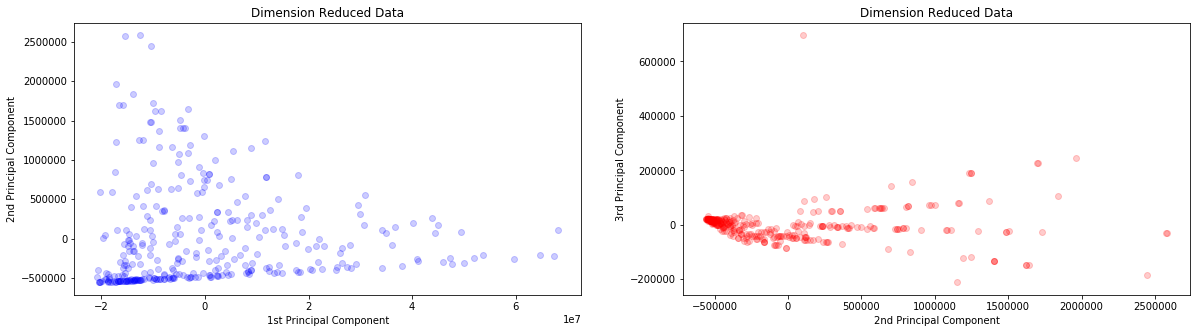

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_train_pca3[:, 1], X_train_pca3[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

# Part (i): Beyond Squared Error
We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$
The lower the RMSLE the better is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases.

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [47]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    where_are_NaNs = np.isnan(np.log(y_pred+1))
    y_pred[where_are_NaNs] = 0
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    print("RMSLE is ", rmsle_)
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g).

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model?

Note: We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [48]:
print("Train:")
RMSLE = rmsle(y_train, lm.predict(X_train))
print("Test:")
RMSLE = rmsle(y_test, lm.predict(X_test))

# Our best guess is that we would use RMSLE to estimate a kind of lambda factor. The idea is that it is a logarithmic measure and
# can measure actual versus predicted values according to this relationship: log((pi+1)/(ai+1)), where pi is the
# predicted value and ai is the actual. It can be used to penalize under-estimates on a different basis than
# over-estimates, as might be the case when the suppliers of the bicycles being studied here are trying to decide how
# many bikes to stock - if people expect to face a stock-out because it is a busy day, you're not so worried about
# estimating demand, but if you underestimate demand on a lighter day, you could make a number of customers angry.
#
# It should be noted that the lambda we are suggesting above would a *multiplier* to *increase* estimated rentals
# givne a high RMSLE than the way we've used it elsewhere here, as a reducer. And it may be outside the regression
# equation entirely, but rather as a "post-processing" multiplier where you estimate rentals given parameters provided
# by the regression, AND THEN apply the multiplier suggested by the RMSLE.

Train:
RMSLE is  3.9844704117976536e-14
Test:
RMSLE is  9.424115049029955e-14


# Part (j): Dealing with Erroneous Labels¶
Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score).

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

Note: Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [49]:
y_train = trainData['count'].values
y_train = y_train[0:-3]
y_train = y_train.reshape(len(y_train), 1)

X_train = trainData[['season', 'month', 'holiday', 'day_of_week', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'temp^2',
       'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2',
       'humidity^3', 'humidity^4', 'windspeed^2', 'windspeed^3',
       'windspeed^4']].values
X_train = X_train[0:-3]
y_test = trainData['count'].values
X_test = trainData[['season', 'month', 'holiday', 'day_of_week', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'temp^2',
       'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2',
       'humidity^3', 'humidity^4', 'windspeed^2', 'windspeed^3',
       'windspeed^4']].values

y_test = y_test.reshape(len(y_test), 1)

print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

print('The equation of the regression plane is: {} + {} * x'.format(lm.intercept_, lm.coef_))

train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

(328, 23) (328, 1) (331, 23) (331, 1)
The equation of the regression plane is: [2.31921149e-10] + [[-4.02111437e-13  4.60436133e-13 -1.02070876e-11 -3.19219428e-12
   7.26878160e-12  5.91995820e-14  1.43551908e-12 -1.67567664e-12
  -5.49244971e-14  3.36996232e-12  1.00000000e+00  2.46006020e-14
  -1.98963026e-15 -2.67831299e-18 -6.93674781e-14  4.82922859e-15
  -2.70158579e-17 -1.06551486e-14 -2.83217494e-15  3.07100265e-17
  -3.06056430e-11  1.33820102e-10 -1.68540812e-10]] * x
The train MSE is 3.939171687566989e-21, the test MSE is 3.918513445628594e-21
The train R^2 is 1.0, the test R^2 is 1.0
